In [1]:
import nltk

# 必要に応じてダウンロード

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [2]:
import re
from typing import Final, TypeAlias

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from nltk.corpus import gutenberg
from numpy.typing import NDArray
from pandas import DataFrame
from shap import Explainer

from authorship_tool.types import Para2dStr, Tag
from authorship_tool.util import dim_reshaper, type_guard
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import trainer as lgbm_trainer
from authorship_tool.util.ml.model import (
    CrossValidationView,
    LGBMSource,
    Score,
    pred_crosstab_loocv,
)
from authorship_tool.util.ml.trainer import calculate_score_by_loocv
from authorship_tool.util.path_util import PathUtil

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...


Project root: /workspaces/shap-authorship-analysis-demo
Path: path_dump_lgbm_model_dir = /workspaces/shap-authorship-analysis-demo/dump/lgbm/model
Path: path_dump_dataset_dir = /workspaces/shap-authorship-analysis-demo/dump/dataset
Path: path_dump_shap_figure_dir = /workspaces/shap-authorship-analysis-demo/dump/shap/figure
Path: path_adjective_past_participle_dataset = /workspaces/shap-authorship-analysis-demo/data/nlp_datasets/wordLists/adjectivesPastParticiple


ImportError: cannot import name 'CvViewData' from 'authorship_tool.util.ml.model' (/workspaces/shap-authorship-analysis-demo/authorship_tool/util/ml/model.py)

In [ ]:
np.seterr(divide="call")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [ ]:
AUTHOR_A: Final[str] = "chesterton"
AUTHOR_B: Final[str] = "bryant"

In [ ]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [ ]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: list[list[Para2dStr]] = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]  # type: ignore

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [ ]:
books_a: list[list[Para2dStr]] = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]  # type: ignore

paras_a: list[Para2dStr] = [para for paras in books_a for para in paras]
if len(paras_a) == 0 or not type_guard.are_paras(paras_a):
    raise ValueError("paras_a is empty or not list[Para]")

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [ ]:
books_b: list[list[Para2dStr]] = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]  # type: ignore

paras_b: list[Para2dStr] = [para for paras in books_b for para in paras]
if len(paras_b) == 0 or not type_guard.are_paras(paras_b):
    raise ValueError("paras_a is empty or not list[list[str]]")

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

[ Stories to Tell to Children by Sara Cone Bryant 1918 ]
TWO LITTLE RIDDLES IN RHYME
There ' s a garden that I ken , Full of little gentlemen ; Little caps of blue they wear , And green ribbons , very fair . ( Flax .)
From house to house he goes , A messenger small and slight , And whether it rains or snows , He sleeps outside in the night . ( The path .)
THE LITTLE YELLOW TULIP
Once there was a little yellow Tulip , and she lived down in a little dark house under the ground . One day she was sitting there , all by herself , and it was very still . Suddenly , she heard a little _tap , tap , tap_ , at the door .
" Who is that ?" she said .
" It ' s the Rain , and I want to come in ," said a soft , sad , little voice .
" No , you can ' t come in ," the little Tulip said .
By and by she heard another little _tap , tap , tap_ on the window - pane .
" Who is there ?" she said .
The same soft little voice answered , " It ' s the Rain , and I want to come in !"
" No , you can ' t come in ," s

In [ ]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")

total: 5249 paragraphs (samples)


In [ ]:
if not (type_guard.are_paras(paras_a) and type_guard.are_paras(paras_b)):
    raise TypeError("paras_a or paras_b is not list[Para]")
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: tuple[Tag, ...] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)

('$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``')


In [ ]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

In [ ]:
para_ans_list: list[tuple[Para2dStr, bool]] = list(
    [(para, True) for para in paras_a] + [(para, False) for para in paras_b]
)

In [ ]:
datasets: NDArray = np.array(
    [
        dataset_generator.generate_from_paragraph(para, answer)
        for para, answer in para_ans_list
    ]
)

In [ ]:
df = DataFrame(datasets[:, :-1], columns=dataset_generator.columns)
nd_category = np.array(datasets[:, -1], dtype=bool)

display(df.head(10))

,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains although,v13 contains however,v14 contains but,v15 contains because,v16 contains this,v17 contains others or researchers,v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains et,word variation,average token length,non alphabetic characters frequency,uncommon word frequency,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_pp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.857143,2.857143,0.571429,0.857143,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.071429,0.071429,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.0,0.000000,0.071429,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,2.0,8.0,0.0,0.0,0.0,0.0,0.0,2.000000,4.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,3.625000,0.125000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,5.0,164.0,0.0,0.0,1.0,0.0,0.0,12.983066,13.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.573171,4.103659,0.091463,0.530488,0.0,0.0,0.000000,0.000000,0.042683,0.030488,0.018293,0.048780,0.006098,0.134146,0.000000,0.006098,0.176829,0.073171,0.006098,0.000000,0.0,0.000000,0.164634,0.012195,0.000000,0.036585,0.000000,0.000000,0.060976,0.000000,0.036585,0.000000,0.000000,0.000000,0.0,0.024390,0.0,0.006098,0.042683,0.018293,0.012195,0.012195,0.024390,0.006098,0.0,0.000000,0.000000,0.0
3,6.0,149.0,0.0,1.0,1.0,0.0,0.0,4.669642,6.200000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.637584,4.389262,0.120805,0.590604,0.0,0.0,0.000000,0.000000,0.067114,0.040268,0.013423,0.013423,0.013423,0.120805,0.000000,0.000000,0.100671,0.053691,0.000000,0.006711,0.0,0.006711,0.127517,0.013423,0.000000,0.046980,0.013423,0.000000,0.046980,0.013423,0.060403,0.000000,0.000000,0.000000,0.0,0.020134,0.0,0.020134,0.087248,0.006711,0.067114,0.013423,0.000000,0.026846,0.0,0.000000,0.000000,0.0
4,8.0,294.0,1.0,0.0,1.0,0.0,0.0,18.699933,22.857143,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.544218,4.125850,0.136054,0.574830,0.0,0.0,0.003401,0.003401,0.085034,0.027211,0.003401,0.037415,0.010204,0.088435,0.003401,0.000000,0.115646,0.105442,0.000000,0.000000,0.0,0.003401,0.122449,0.010204,0.003401,0.034014,0.003401,0.000000,0.064626,0.020408,0.091837,0.000000,0.003401,0.003401,0.0,0.017007,0.0,0.023810,0.068027,0.006803,0.030612,0.003401,0.000000,0.003401,0.0,0.003401,0.000000,0.0
5,5.0,91.0,0.0,1.0,0.0,0.0,0.0,13.511477,15.250000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.758242,4.637363,0.175824,0.593407,0.0,0.0,0.000000,0.000000,0.032967,0.043956,0.000000,0.021978,0.000000,0.076923,0.000000,0.000000,0.131868,0.054945,0.000000,0.000000,0.0,0.010989,0.142857,0.054945,0.000000,0.065934,0.000000,0.000000,0.054945,0.021978,0.054945,0.000000,0.000000,0.000000,0.0,0.054945,0.0,0.054945,0.010989,0.032967,0.010989,0.021978,0.032967,0.010989,0.0,0.000000,0.000000,0.0
6,1.0,50.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.860000,3.480000,0.180000,0.580000,0.0,0.0,0.000000,0.000000,0.040000,0.000000,0.020000,0.020000,0.000000,0.060000,0.000000,0.000000,0.180000,0.020000,0.000000,0.000000,0.

In [ ]:
print(df.shape)

(5249, 68)


In [ ]:
print(df.dtypes)

v1 sentences per paragraph                        float64
v2 words per paragraph                            float64
v3 close parenthesis present                      float64
v4 dash present                                   float64
v5 semi-colon or colon present                    float64
v6 question mark present                          float64
v7 apostrophe present                             float64
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                      float64
v11 sentence with > 34 words                      float64
v12 contains although                             float64
v13 contains however                              float64
v14 contains but                                  float64
v15 contains because                              float64
v16 contains this                                 float64
v17 contains others or researchers                float64
v18 contains n

In [ ]:
print(df.isna().sum())

v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains although                             0
v13 contains however                              0
v14 contains but                                  0
v15 contains because                              0
v16 contains this                                 0
v17 contains others or researchers                0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [ ]:

source: LGBMSource = {"feature_data_frame": df, "nd_category": nd_category}
result: CrossValidationView = lgbm_trainer.train_loocv(source)

[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9756
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9756
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9737
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9764
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9757
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9762
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9757
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9754
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9747
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9762
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9764
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9756
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9754
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9757
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9748
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9754
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9757
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9764
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9754
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9763
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9738
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9762
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9757
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9739
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9748
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9748
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9757
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9762
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9762
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9754
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9770
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9748
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9762
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9763
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9769
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9739
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_col_wise=true` to remove the overhead.


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9748
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9762
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9756
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9739
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9757
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9754
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9749
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9763
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9747
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9767
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9765
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9756
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9746
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9758
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9742
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9764
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9750
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395
[LightGBM] [Info] Number of positive: 4054, number of negative: 1194


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9751
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9752
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9766
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9768
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9759
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9753
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9760
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9743
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 4054, number of negative: 1194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 5248, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.772485 -> initscore=1.222395
[LightGBM] [Info] Start training from score 1.222395


: 

In [ ]:
score: Score = calculate_score_by_loocv(result)

In [ ]:
if score is not None:
    print(f"auc-roc score: {score['auc_roc_score']}")
    print(f"f1 score: {score['f1_score']}")
    print(f"accuracy score: {score['accuracy_score']}")

auc-roc score: 0.8659214092140921
f1 score: 0.9041608228143992
accuracy score: 0.8438690022848438


In [ ]:
display(pred_crosstab_loocv(result))

predicted,False,True
actual,,
False,141,147
True,58,967


In [ ]:
# dump(result, "gutenberg")

In [ ]:
test_data: DataFrame = result["test_data"]
shap_vals = result["shap_positive_vals"]

FIRST_DATA_INDEX: Final[int] = 0

In [ ]:
shap.initjs()

In [ ]:
PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg").mkdir(exist_ok=True)

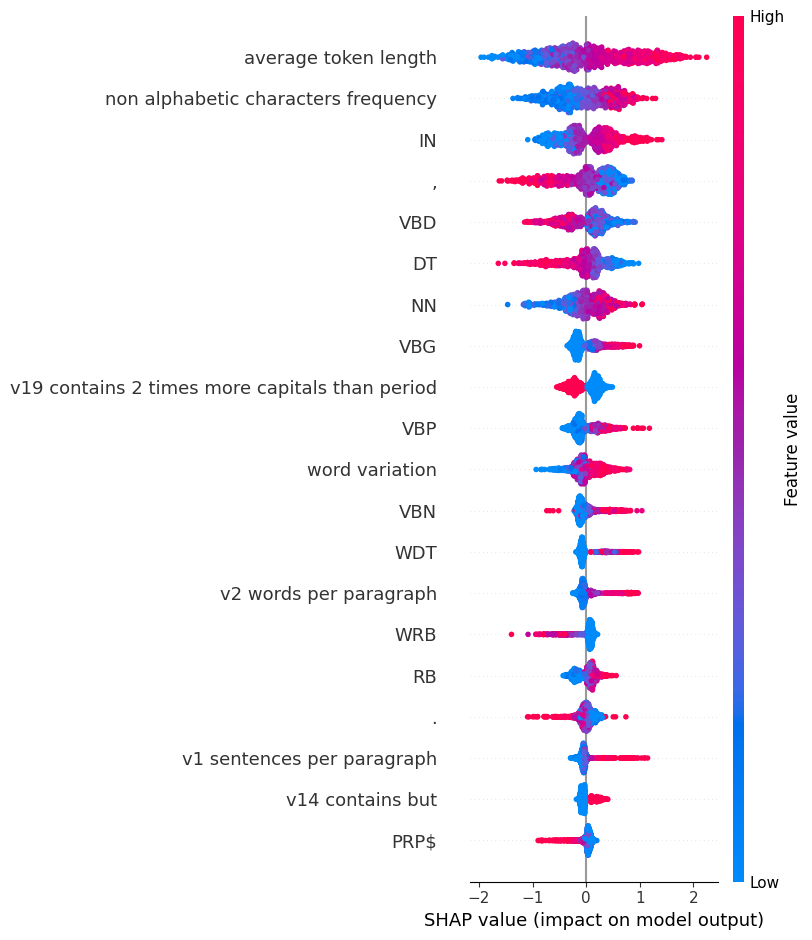

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

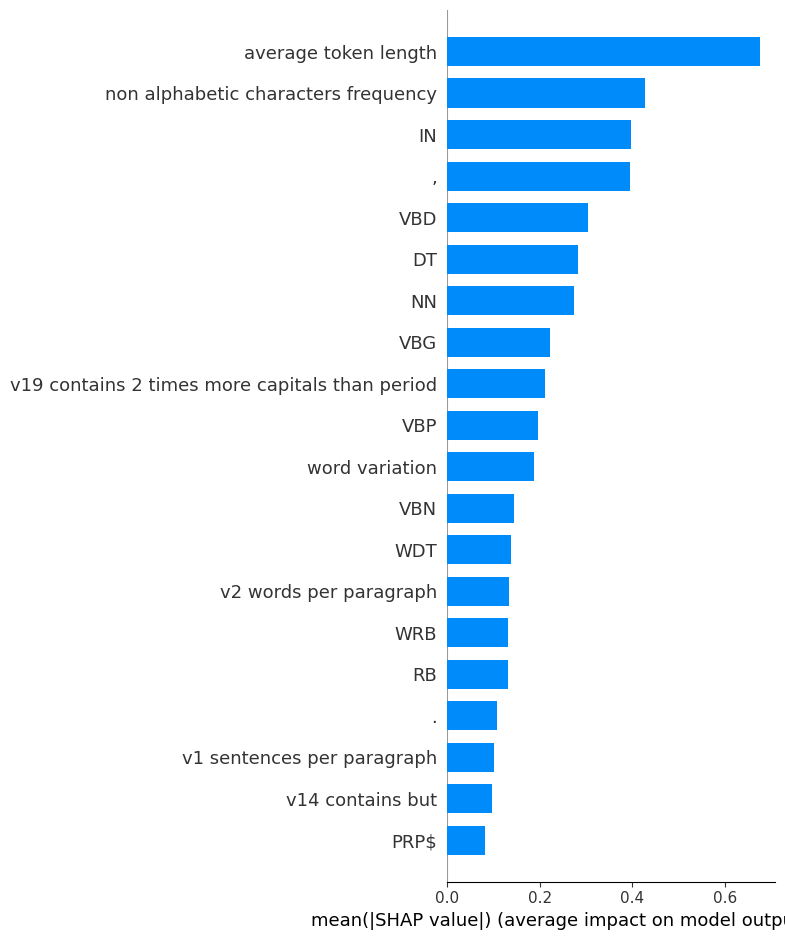

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("gutenberg", "shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()